<a href="https://colab.research.google.com/github/thabied/mypackage/blob/master/Copy_of_FINAL_Kaggle_Challenge_House_Price_Prediction_(Stacked).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kaggel Challenge: House Prices - Advanced Regression Techniques**

---



![alt text](https://www.utahbusiness.com/wp-content/uploads/2017/06/Real-Estate-Banner.jpg)

# Problem Statement

The dataset is comprised of 79 explanatory variables of houses based in Ames, Iowa. Using the wide range of input features, the objective is to predict the single numeric variable (SalePrice) using advanced regression techniques.    

The evaluation metric used for this competition is the Root Mean Squared Error, given by:

![alt text](https://gisgeography.com/wp-content/uploads/2014/07/rmse-formula1-300x96.png)

Examples of sample submissions can be found in the Data Tab of the competition.

# Layout

This notebook is laid out as follows:


> Loading the Dataset


> Exploratory Data Analysis


> Feature Engineering


> Model Compliation and Evaluation


> Submission Code


> Overview













# Get Dataset from Google Drive

This notebook as based on Google Colab in order to make use of Google's free GPU access when training models. In order to access the dataset, the data must be saved in Google Drive and mounted in the Notebook as follows:

In [0]:
# Access the drive and enter authorization code
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/train.csv"

'/content/drive/My Drive/train.csv'


In [0]:
!ls "/content/drive/My Drive/test.csv"

'/content/drive/My Drive/test.csv'


# Convert to Pandas Dataframe

Convert the .csv files into Dataframes

In [0]:
# Pandas conversion
import pandas as pd
train = pd.read_csv('/content/drive/My Drive/train.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')
train = train.set_index('Id')
test = test.set_index('Id')

# Exploratory Data Analysis

Lets take a look and see how the data looks, the data types present and the number of input features present

In [0]:
# Import libraries
import numpy as np
from scipy import stats
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,None,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,None,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,None,None,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,None,MnPrv,None,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,None,None,None,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,None,None,None,0,1,2010,WD,Normal


In [0]:
train.shape

(1460, 80)

In [0]:
test.shape

(1459, 79)

looks like we have 79 input features, of both numeric and categorical, in both the training and testing sets (the SalePrice has been removed from the test.csv file for evaluation), which means our train/test split is 50/50.

Now lets have a look at the missing data.

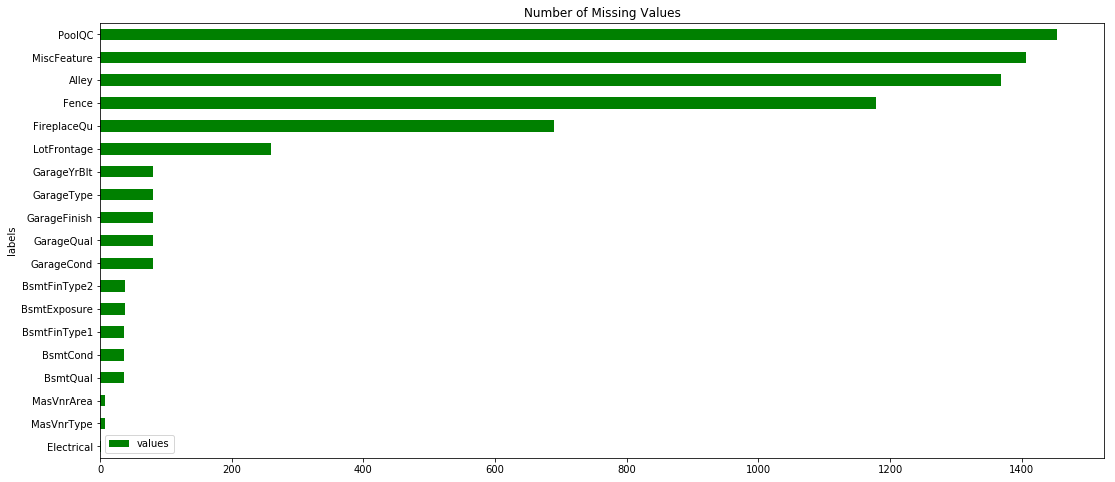

In [0]:
# How many missing values in the Training set
train_labels = []
train_values = []

for col in train.columns:
  if train[col].isnull().sum() > 0:
    train_labels.append(col)
    train_values.append(train[col].isnull().sum())
  
data1 = list(zip(train_labels, train_values))
x1 = pd.DataFrame(data1, columns = ['labels','values'])
desc1 = x1.sort_values(by='values', ascending = True)
desc1.plot(x='labels', y='values',kind='barh', color='g', figsize=(18,8),title="Number of Missing Values", sort_columns=False)
plt.show()

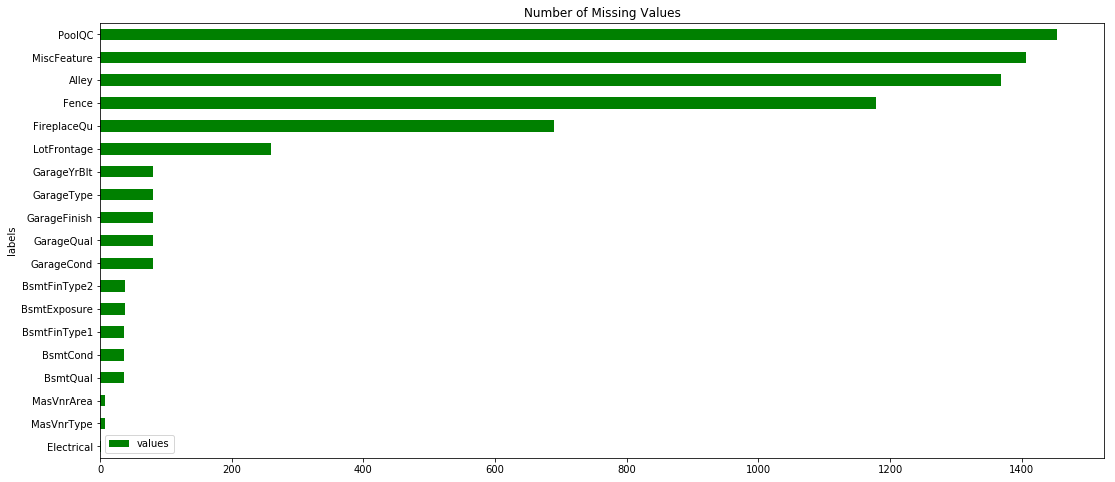

In [0]:
# How many missing values in the Test set
test_labels = []
test_values = []

for col in test.columns:
  if train[col].isnull().sum() > 0:
    test_labels.append(col)
    test_values.append(train[col].isnull().sum())
  
data2 = list(zip(test_labels, test_values))
x2 = pd.DataFrame(data2, columns = ['labels','values'])
desc2 = x2.sort_values(by='values', ascending = True)
desc2.plot(x='labels', y='values',kind='barh', color='g', figsize=(18,8),title="Number of Missing Values", sort_columns=False)
plt.show()

Looks like there are some features that are missing a significant amount of entries. Before decing to drop them, imputation should be considered to preserve the data we have.

Lets take a look at the variable we're predicting. What does the distribution of the SalePrice variable look like compared to a Normal distribution?

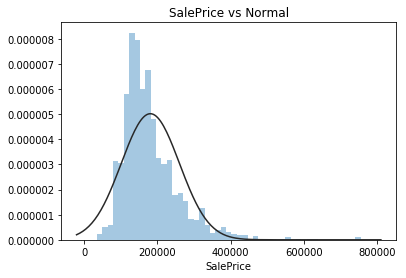

In [0]:
# SalePrice distribution compared to a Normal distribution
plt.figure(1); plt.title('SalePrice vs Normal')
sns.distplot(train['SalePrice'], kde=False, fit=stats.norm)

In [0]:
# Skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


Our Target variable is not Normally distributed. It is skewed, has a fatter right tail and has peakedness.This is important as some machine learning models rely on Normally distrubted variables in order for a model to predict accurately.

Let's have a look at some transformations of the Normal curve such as the Log Normal and Johnson SU distributions to see if they maybe fit better with our Target variable.

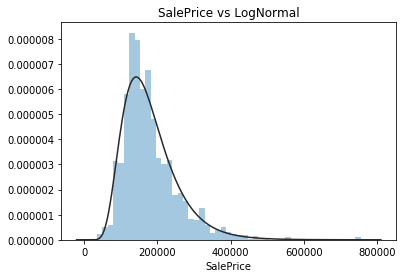

In [0]:
# LogNormal
plt.figure(1); plt.title('SalePrice vs LogNormal')
sns.distplot(train['SalePrice'], kde=False, fit=stats.lognorm)

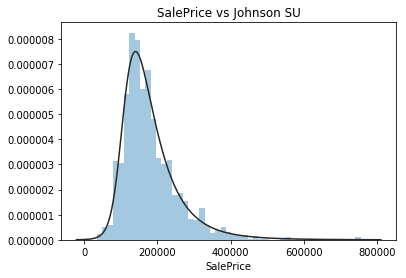

In [0]:
# JohnsonSU
plt.figure(2); plt.title('SalePrice vs Johnson SU')
sns.distplot(train['SalePrice'], kde=False, fit=stats.johnsonsu)

The Johson SU distribution (an adaptation of the Log Normal) best represents the SalePrice distribution as it better accounts for the higher peak and wider tail than the Log Normal does.

Now lets take a look at the distributions of the input features.

*Code adapted from Serigne's Kernel on Kaggle, Titled 'Stacked Regressions : Top 4% on LeaderBoard'*

In [0]:
# Skeweness of input features
x = train.dtypes[train.dtypes != 'object'].index
skewed_features = train[x].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame(skewed_features)
skewness.columns = ['Skew']
skewness.head(10)

,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186
EnclosedPorch,3.086696


Normality is an important assumption in multivariate regression. The top 5 features of the above table are very highly skewed and need to be adjusted in order to satisfy this assumption.

Now lets look at some correlations between Predictor variables and the Target variable and then at the relationships that the input features have within themselves.

In [0]:
# Correlations to Target
x = train.corr()
x = x[['SalePrice']]
x = x.sort_values('SalePrice',ascending=False)

In [0]:
# Top 10
x.head(10)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


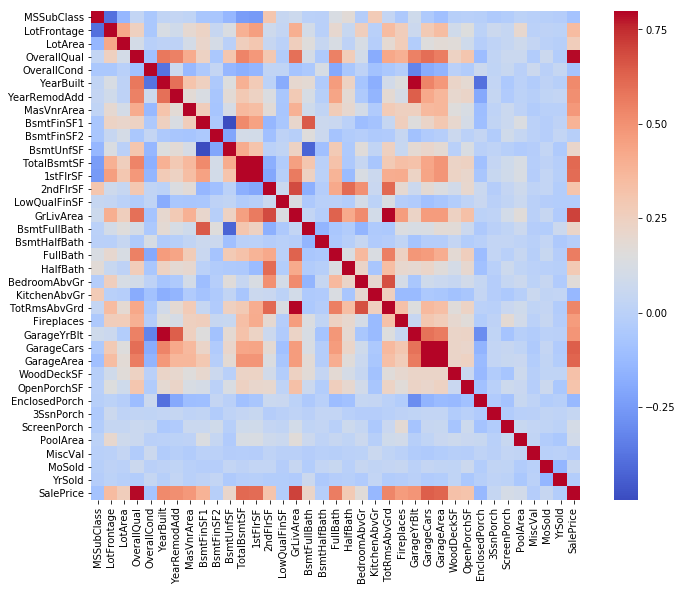

In [0]:
# Heamap
heatmap = train.corr()
plt.figure(figsize=(12,9))
sns.heatmap(heatmap, vmax=.8, square=True, cmap='coolwarm')

OverallQual seems to be most correlated to the SalePrice. Intuitively, this makes sense as the feature's purpose is to give a generalized opinion of the house in one value. Looking at the heatmap, two things pop up. The two white squares along the whie line indicate that there are relationships between TotalBsmtSF and 1stFlrSF. This, again makes sense intuitively because as the size of your first floor increases, so does the size of your basement. Secondly, there's a relationship between GarageCars and GarageArea. Again, as the garage area increases, so does the number of cars it can store.

Dealing with multicolinearity is important with certain ML models as it will affect the model's ability to generalize the relationship we're trying to find.

In the dataset description (http://jse.amstat.org/v19n3/decock.pdf) it's described that there are noteworthy outliers in the GrLvArea to SalePrice relationship. Lets have a look at the scatter plot and see if any outliers can be visually identified.

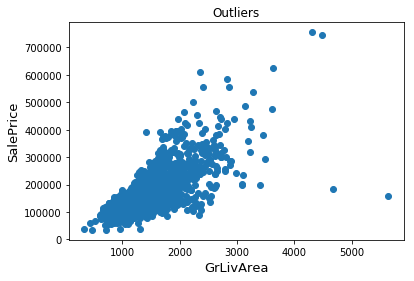

In [0]:
# Create df with Target and GrLivAreatrain = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.title('Outliers')
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In the bottom right of the graph we can see two data points that lie outside of the visualized trend. Outliers can affect certain ML models' ability to accurately make predictions while other models deal with outliers in a more robust way. The trade off lies between having a more accurate model vs having a model that can generalize better to unknown data that may potentially have outliers.

Let's engineer the input features based on the above analysis

# Feature Engineering

First, let's impute/drop features that contain missing values

The dataset description (http://jse.amstat.org/v19n3/decock.pdf) describes how to handle missing values present in the data. For example, the LotFrontage for a specific neighbourhood would be the equal throughout that neighbourhood because the area infront of a house for a given block is shared. Certain missing numeric features can be replaced with 0 because it means that a house does not have a related feature eg. GarageCars can be replaced with zero if GarageArea is zero, which also means the house doesnt have a garage. Categorical missing values can be replaced with either 'None' or the Mode of that feature. All specific feature handling for missing values is contained in the description.

Lets create our X_train and X_test and transform our y_train using the log(1+x) of the SalePrice., append the two predictor variable dataframes and perform feature engineering based on our analysis

In [0]:
# Remove Target variable and use Log of SalePrice
X_train = train.iloc[:, 0:-1]
y_train = train['SalePrice']
y_train = np.log1p(y_train)
X_test = test

In [0]:
data = X_train.append(X_test, sort=False)

Based on the dataset documentation, the missing data points are imputed accordingly. Certain features are alos dropped based on the documentation/intuition. The the majority of the Utilities column is filled with one unique data point with 1 entry missing and another entry that doesn't fit the observed pattern. This feature doesn't offer enough information to gain any insights on and is therefore dropped. PoolQC is dropped as well on account of 99% of the column containing missing values and also on account of the PoolArea supplementing the effect that PoolQC has because if the PoolArea is zero (the house has no pool), the PoolQC is automatically zero and if the house has an entry for the PoolQC feature then automatically there would be an entry for a PoolArea column. Since one complements the other, the feature with the most missing values can be dropped.

In [0]:
# Impute Missing Data

## NaN's = "None"
nones = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual','GarageCond',
         'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','MasVnrType','MSSubClass']
data[nones] = data[nones].fillna('None')

## NaN's = 0
zeros = ['GarageYrBlt', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea']
data[zeros] = data[zeros].fillna(0)

## Most Frequents
frequent = ['MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType']
data[frequent] = data[frequent].fillna(data[frequent].mode())

## LotFrontage
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

## Functional
data["Functional"] = data["Functional"].fillna("Typ")

## Dropped
### Utilities
data = data.drop(['Utilities'], axis=1)
### PoolQC
data = data.drop(['PoolQC'], axis=1)
## Colinear features
data = data.drop(['GarageArea','1stFlrSF'])

In [0]:
# Data types
strings = ['MSSubClass','OverallQual','OverallCond']
data[strings] = data[strings].astype(str)
data.LotFrontage = data.LotFrontage.astype(float)
data.LotArea = data.LotArea.astype(float)

In order to remove redundant data, features can be combined into a single Predictor variable

In [0]:
# Summarize features
data['TotalSF'] = data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF']
data = data.drop(['1stFlrSF','2ndFlrSF','TotalBsmtSF'], axis=1)

data['TotalArea'] = data['LotFrontage'] + data['LotArea']
data = data.drop(['LotFrontage','LotArea'], axis=1)

data['Conditions'] = data['Condition1'] + data['Condition2']
data = data.drop(['Condition1','Condition2'], axis=1)

data['Roof'] = data['RoofStyle'] + data['RoofMatl']
data = data.drop(['RoofStyle','RoofMatl'], axis=1)

data['Exterior'] = data['Exterior1st'] + data['Exterior2nd']
data = data.drop(['Exterior1st','Exterior2nd'], axis=1)

data['BFT'] = data['BsmtFinType1'] + data['BsmtFinType2']
data = data.drop(['BsmtFinType1','BsmtFinType2'], axis=1)

data['BSF'] = data['BsmtFinSF1'] + data['BsmtFinSF2']
data = data.drop(['BsmtFinSF1','BsmtFinSF2'], axis=1)

data['BsmtBath'] = data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath'])
data = data.drop(['BsmtFullBath','BsmtHalfBath'], axis=1)

data['Bath'] = data['FullBath'] + (0.5 * data['HalfBath'])
data = data.drop(['FullBath','HalfBath'], axis=1)

For all input features with a skewness value above 0.5, box-cox transformation is used to normalize them.

*Code adapted from: Nanashi, Kaggle kernel titled '#1 House Prices Solution [top 1%]'.*

In [0]:
# Perform Box Cox transformation on dataset
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

columns = data.dtypes[data.dtypes != 'object'].index
skewed_columns = data[columns].apply(lambda x: skew(x)).sort_values(ascending=False)
                                      
highly_skewed = skewed_columns[skewed_columns > 0.3]
highly_skewed_columns = highly_skewed.index

for i in highly_skewed_columns:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i] + 1))   

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


Use Pandas get_dummies function to convert categorical features and drop the first feature of every split to remove dummy variables.

In [0]:
# Convert Categoricals
data = pd.get_dummies(data, prefix_sep='_', drop_first=True)

In [0]:
# Split dataset
X_train = data.iloc[:1460, :]
X_test = data.iloc[1460:, :]

Remove the outliers from X_train for the model to get a more accurate representation of the relationship.

In [0]:
# Drop outliers
X_train = X_train.drop(X_train[(X_train['GrLivArea']>4000)].index)

All features have been handled and engineered to accomodate a model.

Let's compile some models, evaluate them and optimize a compilation that performs best.

# Blended Models

The model compilation process went from Lasso to RandomForests to Elastic Net to XGBoost. This replicated the content learnt at the time and any suggestions made by supervisors at the time. All hyperparameter tuning was done using GridSearch Cross validation but the code for this has been ommitted in an attempt to save space in the notebook for essential elements of the process.

After the models were developed and their hyperparameters were tuned, they were then evaluated and an ensemble model was then used.

In [0]:
# Import Libraries
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, GridSearchCV, RandomizedSearchCV

RobustScaler is used as it deals with outliers better than StandardScaler and ofcourse to account for models that require input features to be scaled.

In [0]:
# Scale X_train
scaled = RobustScaler()
X_train = scaled.fit_transform(X_train)

In [0]:
xgboost = XGBRegressor(base_scor=1,booster='gbtree',colsample_bytree=1,gamma=0.0002,importance_type='gain',learning_rate=0.01,max_depth=3,
                         min_child_weight=1,n_estimators=3000,n_jobs=1,reg_alpha=0,reg_lambda=1,scale_pos_weight=1,subsample=1)

In [0]:
lasso = LassoCV(max_iter=1e7, alphas=0.0003, random_state=42, cv=10)

In [0]:
elastic_net = ElasticNetCV(max_iter=1e7, alphas=0.0003, cv=10, l1_ratio=0.9)

In [0]:
rf = RandomForestRegressor(bootstrap=False, max_depth=None, max_features=50, min_samples_leaf=1, min_samples_split=2, n_estimators=200)

In [0]:
stacking = StackingCVRegressor(regressors=(xgboost, lasso, elastic_net, rf), meta_regressor=xgboost, use_features_in_secondary=True)

Lets evaluate these models performance on the training set using the cross_val_score function with 10 folds in order to avoid isolating a Validation Set and to also create an environment where the model is tested on out-of-bag samples.

In [0]:
def rmse_test(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10))
    return (rmse)

In [0]:
print("RMSE score for XGBoost:")
print(rmse_test(xgboost).mean())
print("RMSE score for Lasso:")
print(rmse_test(lasso).mean())
print("RMSE score for Elastic Net:")
print(rmse_test(elastic_net).mean())
print("RMSE score for Random Forest:")
print(rmse_test(rf).mean())

RMSE score for XGBoost:
[11:20:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:21:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:21:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:22:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:22:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:23:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:23:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:25:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:25:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.12626018741656148
RMSE score for Lasso:


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


AxisError: ignored

In [0]:
xgb_model = xgboost.fit(X_train, y_train)
lasso_model = lasso.fit(X_train, y_train)
elastic_model = elastic_net.fit(X_train, y_train)
rf_model = rf.fit(X_train, y_train)

In the Kaggle Overview tab there are tutorials and information about Stacking models. StackingCVRegressor uses the input models that are parsed into it, trains each model on a replica of the Predictor variables using a the Cross-Validation method and takes each set of predictions as input featues for a meta-regressor to then find a final set of Predictions. Most top performing kernels in the competition use stacking and ensemble methods for advanced regression models. Since there's always a trade off in Data Science, an important one in Machine Learning is model explainabilty vs model performance. Generally, models that outperform others are harder to explain and interpret while models that are easily understandable usually don't perform as well. In this case, the former was chosen.

![alt text](http://i.imgur.com/QBuDOjs.jpg)

Let's stack the models created, use the strongest one as the meta-regressor and compare the performance to our previous models.

In [0]:
print("RMSE score for Stacking:" rmse(stacking).mean())

In [0]:
y_train = np.array(y_train)

In [0]:
stacking_model = stacking.fit(X_train, y_train)

Each model has it's own pro's and con's. For example, RandomForests are immune to colinearity as the model will identify highly correlated features and split them, while a Lasso model is not. 

So to find an optimal result, these models are all used and the weighting of each is adjusted to the cross-validation performance above.

In [0]:
def blended_prediction(X):
    return ((0.20 * xgb_model.predict(X)) + \
            (0.05 * lasso_model.predict(X)) + \
            (0.05 * elastic_model.predict(X)) + \
            (0.20 * rf_model.predict(X)) + \
            (0.50 * stacking_model.predict(X))
            )

In [0]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, blended_prediction(X_train)))

In [0]:
print('RMSE score on train data:')
print(rmse(y_train, blended_prediction(X_train)))

RMSE score on train data:
0.04776490628260381


# Prediction on X_test

In [0]:
def __init__():
  X = X_test.copy()
  X = scaled.fit_transform(X)
  y_pred = blended_prediction(X)
  y_pred = np.expm1(y_pred)
  y_pred = y_pred.reshape(-1,1)
  y_pred = pd.DataFrame(y_pred)
  y_pred.columns = ['SalePrice']
  shit = test.copy()
  shit = shit.reset_index()
  shit['SalePrice'] = y_pred
  submission = shit[['Id','SalePrice']]
  submission = submission.set_index('Id')
  
  return submission.head()

In [0]:
__init__()

In [0]:
  S = X_test.copy()
  S = scaled.fit_transform(S)
  y_pred = blended_prediction(A)
  y_pred = np.expm1(y_pred)
  y_pred = y_pred.reshape(-1,1)
  y_pred = pd.DataFrame(y_pred)
  y_pred.columns = ['SalePrice']
  sub = test.copy()
  sub = sub.reset_index()
  sub['SalePrice'] = y_pred
  submission = sub[['Id','SalePrice']]
  submission = submission.set_index('Id')

In [0]:
from google.colab import files

submission.to_csv('submission.csv')
files.download('submission.csv')